Team members:

Name: Xi Yu
StudentID: 22015116

Name: Chenxin Li
Student ID: 22066519

The second line in the book should be a comment stating if the code executes to the end without an error.

The third line in the book should be a comment with a link to the original source where you opted to reuse an existing implementation.


try cnn here, refer to https://www.kaggle.com/code/mdmosarrofhossen/brain-tumor-detection-accuracy-100-val-acc-100

kaggle dataset here: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

maybe not enough large. We will try to train and see the process time.

Add GPU to accelerate

In [ ]:
import time
start_time = time.time()

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(device_name)
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.device('/device:GPU:0')

Found GPU at: /device:GPU:0


In [ ]:
!rm -rf Brain_MRI_Image
! git clone https://github.com/TravellerXi/Brain_MRI_Image

Cloning into 'Brain_MRI_Image'...
remote: Enumerating objects: 3031, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 3031 (delta 4), reused 242 (delta 4), pack-reused 2789
Receiving objects: 100% (3031/3031), 78.64 MiB | 23.96 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (3128/3128), done.


In [ ]:
! ls

Brain_MRI_Image  gdrive  model	sample_data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#intializing the image size and batch size
height = 244
width = 244
batch_size=32

In [ ]:
dataset_train_dir = "Brain_MRI_Image/train/"
dataset_test_dir = "Brain_MRI_Image/test/"

In [ ]:
datagen_test = ImageDataGenerator(
            rescale=1./255.,
            )

test_ds=datagen_test.flow_from_directory(
        dataset_test_dir,
        shuffle=True,
        batch_size=32,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )
print(test_ds)


Found 38 images belonging to 2 classes.


In [ ]:
def image_gen(height, width):
    datagen_train = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen_train.flow_from_directory(
        dataset_train_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )
    
    val_ds = datagen_train.flow_from_directory(
        dataset_train_dir,
        batch_size=batch_size,
        subset="validation",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )

   
    return train_ds, val_ds
    

#train_ds, val_ds, test_ds = image_gen(height, width)
train_ds, val_ds = image_gen(height, width)


total_images = np.concatenate([train_ds.labels, val_ds.labels,test_ds.labels])
print('\n\n',{"No brain tumor cases": len(np.where(total_images==0)[0]),
             "Brain tumor cases": len(np.where(total_images==1)[0])})


Found 2469 images belonging to 2 classes.
Found 616 images belonging to 2 classes.


 {'No brain tumor cases': 493, 'Brain tumor cases': 2630}


In [ ]:
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.models import Sequential, load_model

In [ ]:
from keras.models.cloning import sequential
tf.keras.backend.clear_session()
model = ResNet50V2(input_shape=(244,244,3), include_top=False,pooling="avg")
model.trainable = True
# resnet50v2 source code https://github.com/keras-team/keras/blob/v2.11.0/keras/applications/resnet_v2.py#L30-L62


model.compile(optimizer=Adam(), 
               loss="sparse_categorical_crossentropy", 
               metrics=['accuracy'])
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 250, 250, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 122, 122, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50v2_best.h5', 
                                                monitor='val_loss', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Epoch 1/30
78/78 [==============================] - ETA: 0s - loss: 1.5903 - accuracy: 0.7209
Epoch 1: val_loss improved from -inf to 2.07947, saving model to model/resnet50v2_best.h5
78/78 [==============================] - 49s 472ms/step - loss: 1.5903 - accuracy: 0.7209 - val_loss: 2.0795 - val_accuracy: 0.0000e+00
Epoch 2/30
78/78 [==============================] - ETA: 0s - loss: 0.8223 - accuracy: 0.8117
Epoch 2: val_loss did not improve from 2.07947
78/78 [==============================] - 32s 408ms/step - loss: 0.8223 - accuracy: 0.8117 - val_loss: 1.9459 - val_accuracy: 0.0000e+00
Epoch 3/30
78/78 [==============================] - ETA: 0s - loss: 3.5909 - accuracy: 0.4690
Epoch 3: val_loss improved from 2.07947 to 6.37215, saving model to model/resnet50v2_best.h5
78/78 [==============================] - 35s 447ms/step - loss: 3.5909 - accuracy: 0.4690 - val_loss: 6.3721 - val_accuracy: 0.1851
Epoch 4/30
78/78 [==============================] - ETA: 0s - loss: 4.0104 - accurac

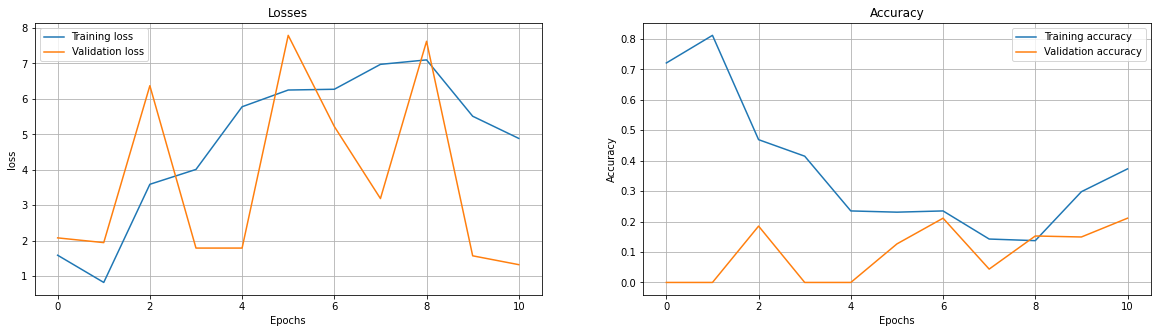

In [ ]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

In [ ]:
print("--- %s minutes ---" % (int(time.time() - start_time)/60))

--- 7.633333333333334 minutes ---


In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)

2/2 [==============================] - 1s 759ms/step - loss: 7.6736 - accuracy: 0.4211


In [ ]:
print("test loss is: ", test_loss, "test accuracy is: ", test_accuracy)

test loss is:  7.673553466796875 test accuracy is:  0.42105263471603394
